# House Prices - Advanced Regression Techniques (Kaggle)

Run after following notebooks are run:
1. 01 Data Cleaning
2. 02 Exploratory Data Analysis

#### Development Ideas
*  Need to scale discrete numerical variables as well

In [37]:
### set up libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import seaborn as sns

pd.options.display.max_rows = 100

## Load Data

In [2]:
### load data (cleaned)
train = pd.read_csv('train_clean_truncated.csv')
test = pd.read_csv('test_clean.csv')

### convert all object datatypes to category
for col in train.select_dtypes(include='object'):
    train[col] = train[col].astype('category')

for col in test.select_dtypes(include='object'):
    test[col] = test[col].astype('category')

### convert additional columns to category datatype
train['MSSubClass'] = train['MSSubClass'].astype('category')
test['MSSubClass'] = test['MSSubClass'].astype('category')

train.shape, test.shape

((1460, 67), (1459, 80))

In [3]:
## separate in to predictor and response tables (x and y)
x_train = train.drop('SalePrice', axis=1)
y_train = train.SalePrice

## for the test data, take only the x vars present in the train data,
x_train_cols = x_train.columns.to_list()
x_test = test[x_train_cols]

## One Hot Encoding

In [4]:
x_train_onehot = pd.get_dummies(x_train, drop_first=True)
x_test_onehot = pd.get_dummies(x_test, drop_first=True)
print(x_train_onehot.shape, x_test_onehot.shape)
x_train_onehot.columns.to_list()

(1460, 200) (1459, 196)


['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'MoSold',
 'YrSold',
 'age_sold',
 'age_remodel_sold',
 'age_garage_sold',
 'bsmt_bath',
 'bath',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Alley_Pave',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LotConfig_FR',
 'LotConfig_Inside',
 'LandSlope_MOrS',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_C

In [5]:
## add on missing columns to train data due to onehot encoding
train_cols_to_add = [var for var in x_test_onehot.columns.to_list() if var not in x_train_onehot.columns.to_list()]
for var in train_cols_to_add:
    x_train_onehot[var] = False

## add on missing columns to test data due to onehot encoding
test_cols_to_add = [var for var in x_train_onehot.columns.to_list() if var not in x_test_onehot.columns.to_list()]
for var in test_cols_to_add:
    x_test_onehot[var] = False

print(x_train_onehot.shape, x_test_onehot.shape)

(1460, 201) (1459, 201)


## Modelling - Cross-Validation and Optimisation

### Random Forest

{'min_samples_split': 20, 'n_estimators': 220, 'n_jobs': -1}


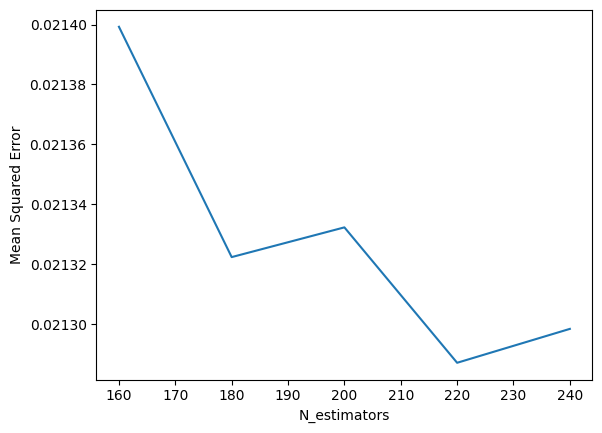

In [6]:
## hyperparameter tuning: n_estimators
param_grid = {'n_estimators' : np.arange(160,250,20), 'min_samples_split' : [20], 'n_jobs' : [-1]}
kf = KFold(n_splits=10, shuffle=True, random_state=8)

rf_tuning = GridSearchCV(RandomForestRegressor(random_state=8), param_grid, scoring='neg_mean_squared_error', cv=kf)
rf_tuning.fit(x_train_onehot.values, y_train.values)
rf_tuning_params = rf_tuning.cv_results_['param_n_estimators']
rf_tuning_mse = -rf_tuning.cv_results_['mean_test_score']

## find best param with lowest mse, and plot params against mse
print(rf_tuning.best_params_)
plt.plot(rf_tuning_params, rf_tuning_mse)
plt.xlabel('N_estimators')
plt.ylabel('Mean Squared Error')
None

In [7]:
## instantiate rf algorithm, using best tuned param
rf = RandomForestRegressor(n_estimators=220, random_state=8, min_samples_split=20, n_jobs=-1)

## cross validation
kf = KFold(n_splits=6, shuffle=True, random_state=8)
rf_cv_scores = cross_val_score(rf, x_train_onehot.values, y_train.values, scoring='neg_mean_squared_error', cv=kf)
print(f'avg MSE: {-np.mean(rf_cv_scores)}\n', f'splits MSE: {-rf_cv_scores}')

avg MSE: 0.021545980941744272
 splits MSE: [0.01671994 0.02171246 0.03020041 0.0182659  0.0235479  0.01882927]


In [8]:
## List feature importance
rf.fit(x_train_onehot.values, y_train.values)
rf_ft_imp = pd.DataFrame(data={'Features': x_train_onehot.columns, 'Gini Importance':rf.feature_importances_*100})
rf_ft_imp.sort_values(by='Gini Importance', ascending=False).head(15)

,Features,Gini Importance
2,OverallQual,57.712621
11,GrLivArea,11.453307
8,TotalBsmtSF,4.852367
16,GarageCars,4.754461
17,GarageArea,2.572136
9,1stFlrSF,2.332334
5,BsmtFinSF1,2.098833
166,CentralAir_Y,1.728878
3,OverallCond,1.123377
1,LotArea,0.965328


### KNN

{'n_neighbors': 8}


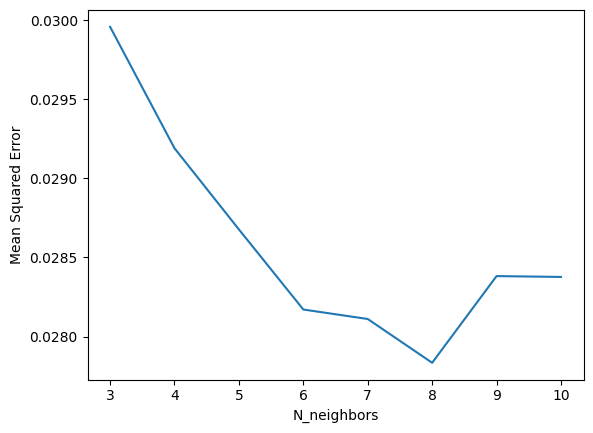

In [9]:
## limit x vars to top 10 by gini importance (determined in rf section)
top10_vars = rf_ft_imp.sort_values(by='Gini Importance', ascending=False).head(10)['Features'].to_list()
x_train_onehot_top10 = x_train_onehot[top10_vars]
x_test_onehot_top10 = x_test_onehot[top10_vars]

## hyperparameter tuning: alpha
param_grid = {'n_neighbors' : np.arange(3,11)}
kf = KFold(n_splits=6, shuffle=True, random_state=8)

knn_tuning = GridSearchCV(KNeighborsRegressor(weights='distance'), param_grid, scoring='neg_mean_squared_error', cv=kf)
knn_tuning.fit(x_train_onehot_top10.values, y_train.values)
knn_tuning_params = knn_tuning.cv_results_['param_n_neighbors']
knn_tuning_mse = -knn_tuning.cv_results_['mean_test_score']

## find best param with lowest mse, and plot params against mse
print(knn_tuning.best_params_)
plt.plot(knn_tuning_params, knn_tuning_mse)
plt.xlabel('N_neighbors')
plt.ylabel('Mean Squared Error')
None

In [10]:
## instantiate knn algorithm, using best tuned param
knn = KNeighborsRegressor(n_neighbors=8, weights='distance')

## cross validation
kf = KFold(n_splits=6, shuffle=True, random_state=8)
knn_cv_scores = cross_val_score(knn, x_train_onehot_top10.values, y_train.values, scoring='neg_mean_squared_error', cv=kf)
print(f'avg MSE: {-np.mean(knn_cv_scores)}\n', f'splits MSE: {-knn_cv_scores}')

avg MSE: 0.027834088906181498
 splits MSE: [0.02614684 0.0253417  0.03547027 0.02685103 0.02784385 0.02535085]


### Lasso

{'alpha': 0.0005736842105263159}


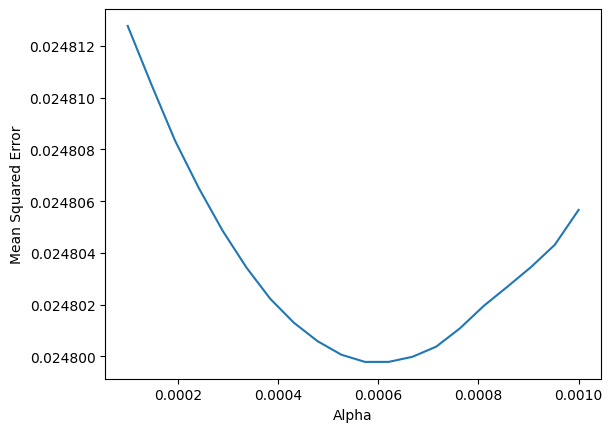

In [11]:
## hyperparameter tuning: alpha
param_grid = {'alpha': np.linspace(0.0001, 0.001, 20)}
kf = KFold(n_splits=10, shuffle=True, random_state=8)

lasso_tuning = GridSearchCV(Lasso(random_state=8), param_grid, scoring='neg_mean_squared_error', cv=kf)
lasso_tuning.fit(x_train_onehot_top10.values, y_train.values)
lasso_tuning_params = lasso_tuning.cv_results_['param_alpha']
lasso_tuning_mse = -lasso_tuning.cv_results_['mean_test_score']

## find best param with lowest mse, and plot params against mse
print(lasso_tuning.best_params_)
plt.plot(lasso_tuning_params, lasso_tuning_mse)
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
None

In [12]:
## instantiate rf algorith, using best tuned param
lasso = Lasso(alpha=0.000574)

## cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=8)
lasso_cv_scores = cross_val_score(lasso, x_train_onehot_top10.values, y_train.values, scoring='neg_mean_squared_error', cv=kf)
print(f'avg MSE: {np.mean(-lasso_cv_scores)}\n', f'splits MSE: {-lasso_cv_scores}')

avg MSE: 0.02477802340191591
 splits MSE: [0.02290958 0.0262464  0.0216218  0.02217577 0.03093657]


### Elastic Net

* Did't follow through with Elastic Net as it would give similar results to lasso (since optimal l1_ratio ~1)

In [13]:
## hyperparameter tuning: alpha
param_grid = {'alpha': np.linspace(0.0001, 0.0003, 20), 'l1_ratio': [0.7, 0.8, 0.9]}
kf = KFold(n_splits=6, shuffle=True, random_state=8)

elnet_tuning = GridSearchCV(ElasticNet(random_state=8), param_grid, scoring='neg_mean_squared_error', cv=kf)
elnet_tuning.fit(x_train_onehot.values, y_train.values)

## find best param with lowest mse, and plot params against mse
print(elnet_tuning.best_params_, -elnet_tuning.best_score_)

{'alpha': 0.0003, 'l1_ratio': 0.9} 0.01628929449062718


### AdaBoost

{'learning_rate': 0.1, 'n_estimators': 310}


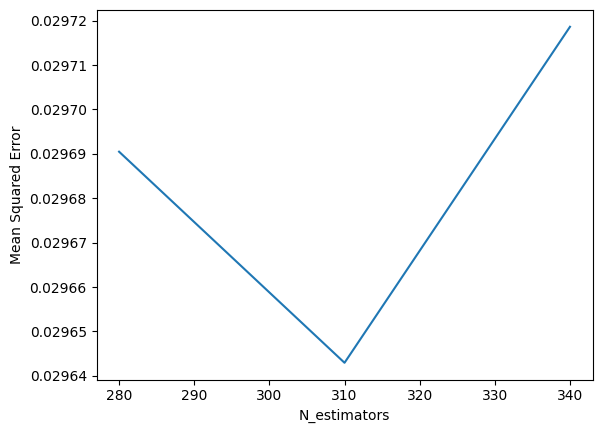

In [14]:
## hyperparameter tuning: n_estimators
param_grid = {'n_estimators' : np.arange(280,350,30), 'learning_rate': [0.1]}
kf = KFold(n_splits=10, shuffle=True, random_state=8)

ada_tuning = GridSearchCV(AdaBoostRegressor(random_state=8), param_grid, scoring='neg_mean_squared_error', cv=kf)
ada_tuning.fit(x_train_onehot.values, y_train.values)
ada_tuning_params = ada_tuning.cv_results_['param_n_estimators']
ada_tuning_mse = -ada_tuning.cv_results_['mean_test_score']

## find best param with lowest mse, and plot params against mse
print(ada_tuning.best_params_)
plt.plot(ada_tuning_params, ada_tuning_mse)
plt.xlabel('N_estimators')
plt.ylabel('Mean Squared Error')
None

In [15]:
## instantiate ada algorithm, using best tuned param
ada = AdaBoostRegressor(n_estimators=310, learning_rate=0.1, random_state=8)

## cross validation
kf = KFold(n_splits=6, shuffle=True, random_state=8)
ada_cv_scores = cross_val_score(ada, x_train_onehot.values, y_train.values, scoring='neg_mean_squared_error', cv=kf)
print(f'avg MSE: {-np.mean(ada_cv_scores)}\n', f'splits MSE: {-ada_cv_scores}')

avg MSE: 0.03002645535057227
 splits MSE: [0.0256292  0.03205437 0.03642366 0.02686595 0.03181638 0.02736918]


### XGBoost

{'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 1100, 'n_jobs': -1}


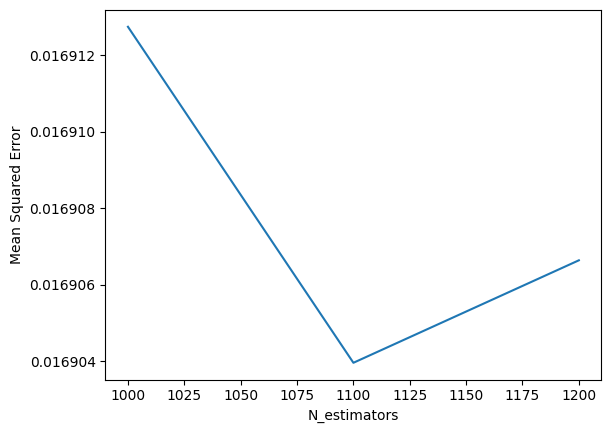

In [16]:
## hyperparameter tuning: n_estimators
param_grid = {'n_estimators' : np.arange(1000,1300,100), 'learning_rate': [0.03], 'max_depth': [3], 'n_jobs': [-1]}
kf = KFold(n_splits=10, shuffle=True, random_state=8)

xgb_tuning = GridSearchCV(xgb.XGBRegressor(random_state=8), param_grid, scoring='neg_mean_squared_error', cv=kf)
xgb_tuning.fit(x_train_onehot.values, y_train.values)
xgb_tuning_params = xgb_tuning.cv_results_['param_n_estimators']
xgb_tuning_mse = -xgb_tuning.cv_results_['mean_test_score']

## find best param with lowest mse, and plot params against mse
print(xgb_tuning.best_params_)
plt.plot(xgb_tuning_params, xgb_tuning_mse)
plt.xlabel('N_estimators')
plt.ylabel('Mean Squared Error')
None

In [17]:
## instantiate ada algorithm, using best tuned param
xgbr = xgb.XGBRegressor(n_estimators=1100, learning_rate=0.03, max_depth=3, random_state=8, n_jobs=-1)

## cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=8)
xgbr_cv_scores = cross_val_score(xgbr, x_train_onehot.values, y_train.values, scoring='neg_mean_squared_error', cv=kf)
print(f'avg MSE: {-np.mean(xgbr_cv_scores)}\n', f'splits MSE: {-xgbr_cv_scores}')

avg MSE: 0.016903958014483845
 splits MSE: [0.00936531 0.02229657 0.01873481 0.01934366 0.01919982 0.01640472
 0.01700227 0.0198026  0.01295068 0.01393915]


### Stacking

In [48]:
## stack rf, knn and lasso using ridge meta estimator
regressors = [
    ('knn', knn),
    ('lasso', lasso)
]
kf = KFold(n_splits=10, shuffle=True, random_state=8)

stack_a = StackingRegressor(estimators=regressors, final_estimator=LinearRegression(fit_intercept=False), cv=kf, n_jobs=-1, passthrough=True)

## Test Prediction

In [49]:
## fit all above models
rf.fit(x_train_onehot.values, y_train.values)
knn.fit(x_train_onehot_top10.values, y_train.values)
lasso.fit(x_train_onehot_top10.values, y_train.values)
ada.fit(x_train_onehot.values, y_train.values)
xgbr.fit(x_train_onehot.values, y_train.values)
stack_a.fit(x_train_onehot.values, y_train.values)
None

In [50]:
## rf prediction
y_testpred_rf = rf.predict(x_test_onehot.values)
y_testpred_rf = np.exp(y_testpred_rf)

## knn prediction
y_testpred_knn = knn.predict(x_test_onehot_top10.values)
y_testpred_knn = np.exp(y_testpred_knn)

## lasso prediction
y_testpred_lasso = lasso.predict(x_test_onehot_top10.values)
y_testpred_lasso = np.exp(y_testpred_lasso)

## ada prediction
y_testpred_ada = ada.predict(x_test_onehot.values)
y_testpred_ada = np.exp(y_testpred_ada)

## xgbr prediction
y_testpred_xgbr = xgbr.predict(x_test_onehot.values)
y_testpred_xgbr = np.exp(y_testpred_xgbr)

## rf x lasso stacked average prediction
y_testpred_stacked_rflasso = (y_testpred_rf + y_testpred_lasso)/2

## knn x lasso stacked average prediction
y_testpred_stacked_knnlasso = (y_testpred_knn + y_testpred_lasso)/2

## stack a (rf, knn, lasso w/ ridge) prediction
y_testpred_stack_a = stack_a.predict(x_test_onehot.values)
y_testpred_stack_a = np.exp(y_testpred_stack_a)

### Save Predictions

In [51]:
## save in submission format - i.e. Id & SalePrice
Id = np.arange(len(train)+1, len(train)+len(test)+1)

# y_testpred_rf = pd.DataFrame(data={'Id':Id, 'SalePrice':y_testpred_rf})
# y_testpred_knn = pd.DataFrame(data={'Id':Id, 'SalePrice':y_testpred_knn})
# y_testpred_lasso = pd.DataFrame(data={'Id':Id, 'SalePrice':y_testpred_lasso})
# y_testpred_ada = pd.DataFrame(data={'Id':Id, 'SalePrice':y_testpred_ada})
# y_testpred_xgbr = pd.DataFrame(data={'Id':Id, 'SalePrice':y_testpred_xgbr})
# y_testpred_stacked_rflasso = pd.DataFrame(data={'Id':Id, 'SalePrice':y_testpred_stacked_rflasso})
# y_testpred_stacked_knnlasso = pd.DataFrame(data={'Id':Id, 'SalePrice':y_testpred_stacked_knnlasso})
y_testpred_stack_a = pd.DataFrame(data={'Id':Id, 'SalePrice':y_testpred_stack_a})

## save a csv
# y_testpred_rf.to_csv('Submissions/test_pred_rf_v5.csv', index=False)
# y_testpred_knn.to_csv('Submissions/test_pred_knn_v4.csv', index=False)
# y_testpred_lasso.to_csv('Submissions/test_pred_lasso_v5.csv', index=False)
# y_testpred_ada.to_csv('Submissions/test_pred_ada_v1.csv', index=False)
# y_testpred_xgbr.to_csv('Submissions/test_pred_xgbr_v2.csv', index=False)
# y_testpred_stacked_knnlasso.to_csv('Submissions/test_pred_stacked_v3.csv', index=False)
y_testpred_stack_a.to_csv('Submissions/test_pred_stackA_v5.csv', index=False)